# Lab 6 CNNS

### Eli Laird

## Introduction

It is estimated that 23,820 adults in the United States will be diagnosed with brain cancer in 2019. Brain and central nervous system cancer is the tenth leading cause of death for men and women in the United States. The 5-year survival rate for men and women with brain cancer is estimated to be between 34 and 36 percent [1]. Early detection of brain tumors is critical in effectively treating patients with brain tumors. In this lab, we will investigate methods for detecting brain tumors using deep Convolutional Neural Networks and Magnetic Resonance Imaging (MRI).

## Business Understanding


##### **Motivation**

The ability to detect and treat a low-grade glioma, today, before it progresses to Glioblastoma multiforme, i.e. brain cancer, can be the difference between life and death [2]. In the past decade, advancements in medical imaging have greatly improved the ability of doctors to diagnose brain tumors without performing exploratory surgery. Exploratory surgery is invasive and introduces many risks to the patient. Magnetic Resonance Imaging, MRI, and Computer-Assisted Tools, CAT scans, are some of the most popular medical imaging techniques used to diagnose brain tumors. These imaging techniques are also used in tumor segmentation and operation planning to provide precision and diagnosis consistency. Using Deep Learning to assist in the diagnosing process can improve the precision of a diagnosis by a considerable amount. In a study of brain tumor diagnosis by the Royal College of Physicians, 10% of patients, in a Scottish audit, had negative CT scans, i.e. a false negative claiming there were no signs of a brain tumor when in fact a brain tumor existed [3]. A negative scan can prove to be fatal as the undetected tumor grows to a higher grade state and will eventually spread to an unrecoverable state. Using Deep Learning to assist in brain tumor diagnosis aims to alleviate this problem by combining the abilities of Convolutional Neural Networks and the domain knowledge of general practictioners to increase the reliability of diagnosing brain tumors. 

##### **Solution**

Convolutional Neural Networks (CNNs) work by applying layers of convolutions to an image to learn specific features of that image. These convolutions apply various filters over the image that correspond to these specific features. For example, a certain filter can be trained to highlight sharp edges in the image, other filters can be learned to focuss on faces or in our case brain tumors. Our Deep Learning solution to early brain tumor detection includes feeding MRI brain scans through different convolutional neural network architectures. Each of these architectures will learn the features of the images and will identify brain scans in which a tumor exists. This solution will allow doctors to make more reliable decisions when  diagnosing a patient with a brain tumor. This solution is not designed to diagnose patients without the assistance of the doctor, however. This solution is designed to provide the doctor with more precise information for the diagnosis and thus act as an aid in order to prevent the scenario where a tumor goes undetected.

##### **Evaluation**

As mentioned before, when diagnosing patients with brain cancer, we want to minimize the amount of undetected brain tumors. This corresponds to having a low false negative rate. Having a low false negative rate is important because a diagnosis that states a patient is cancer free when the patient actually has cancer, that patient will go untreated and the cancer has a higher chance of being fatal. We also do not want to diagnose healthy patients with cancer when they are cancer free because the patient will then go through immense amounts of stress and maybe even go through unnecessary treatment. While false positives are clearly not beneficial to the patient, in the end we consider a false negative more of a detrimental cost because it involves failing to save a life. For this reason we will use the recall metric in evaluating our CNN solution. The recall metric is the ratio of correctly predicted positive observations to all observations of the class. Recall places an emphasis on minimizing false negatives and thus proves to be the most appropriate metric to evaluate our solution. Recall is defined as:

$$
\begin{align}
Recall = \frac{True Positives}{True Positives + False Negatives}
\end{align}
$$



## Data Preparation

In [3]:
import pandas as pd
import numpy as np
%matplotlib inline 
from matplotlib import pyplot as plt
import cv2
import os

In [4]:
file_path = './Brain-Tumor-Images-Dataset/full-data/'

hem_images_dir = os.listdir(file_path + 'hemmorhage_data/')
nonhem_images_dir = os.listdir(file_path + 'non_hemmorhage_data/')


hemmorhage_imgs = []
nonhemmorhage_imgs = []
labels = []
h, w = (250, 150)

#read in hemmorhage images
error_count = 0
for img in hem_images_dir:
    image = cv2.imread(file_path + 'hemmorhage_data/' + img, cv2.IMREAD_GRAYSCALE) 
    image = cv2.resize(image, (150, 250))
    try:
        hemmorhage_imgs.append(image.flatten())
        labels.append(1)
    except:
        error_count += 1
    
#read in nonhemmorage data
for img in nonhem_images_dir:
    image = cv2.imread(file_path + 'non_hemmorhage_data/' + img, cv2.IMREAD_GRAYSCALE) 
    image = cv2.resize(image, (150, 250))
    try:
        nonhemmorhage_imgs.append(image.flatten())
        labels.append(0)
    except:
        error_count += 1
        
        
data = hemmorhage_imgs + nonhemmorhage_imgs
data = np.array(data)
labels = np.array(labels)

#shuffle data
rstate = np.random.get_state()
np.random.shuffle(data)
np.random.set_state(rstate)
np.random.shuffle(labels)

print("{} Images failed to read".format(error_count))
print("Image size:", data[0].shape)
print("Image count:", len(data))

0 Images failed to read
Image size: (37500,)
Image count: 200


#### Data Expansion using Image Transformations

In [5]:
#create new sample data
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=5, # used, Int. Degree range for random rotations.
    width_shift_range=0.1, # used, Float (fraction of total width). Range for random horizontal shifts.
    height_shift_range=0.1, # used,  Float (fraction of total height). Range for random vertical shifts.
    shear_range=0., # Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=None)

#expand dimensions
data = np.expand_dims(data.reshape((-1, h, w)), axis=3)

datagen.fit(data)

new_hemmorhages = datagen.flow(data, labels, batch_size=1000)

In [53]:
i = 0
for tmp in new_hemmorhages:
    if i == 1000: break
    i = i+1
    if i % 50 == 0: print("{} images added".format(i))
    #plt.imshow(tmp[0][0].squeeze(),cmap='bone')
    #plt.title(tmp[1][0])
    data = np.vstack((data,np.expand_dims(tmp[0][0].squeeze().reshape((-1,h,w)), axis=3)))
    labels = np.append(labels,tmp[1][0])
    

50 images added
100 images added
150 images added
200 images added
250 images added
300 images added
350 images added
400 images added
450 images added
500 images added
550 images added
600 images added
650 images added
700 images added
750 images added
800 images added
850 images added
900 images added
950 images added
1000 images added


In [54]:
import pickle 

#store image dataset in pickle file
pickle.dump(data, open('image_data.p', 'wb'))
pickle.dump(labels, open('image_labels.p', 'wb'))

In [6]:
import pickle

#load data from pickle file
data = pickle.load(open('image_data.p', 'rb'))
labels = pickle.load(open('image_labels.p', 'rb'))

In [7]:
# select random images to visualize
import random
random.seed(1)

classes = {1:"Tumor", 0:"No Tumor"}

# function to plot images in grid like fashion
def plot_gallery(images, title, h, w, n_row=3, n_col=6):
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    rand_sample = random.sample(range(0,images.shape[0]), k=18)
    for n,i in enumerate(rand_sample):
        plt.subplot(n_row, n_col, n + 1)
        plt.imshow(images[i].reshape((h,w)))
        plt.title(classes[title[i]], size=12)
        plt.xticks(())
        plt.yticks(())
        
        


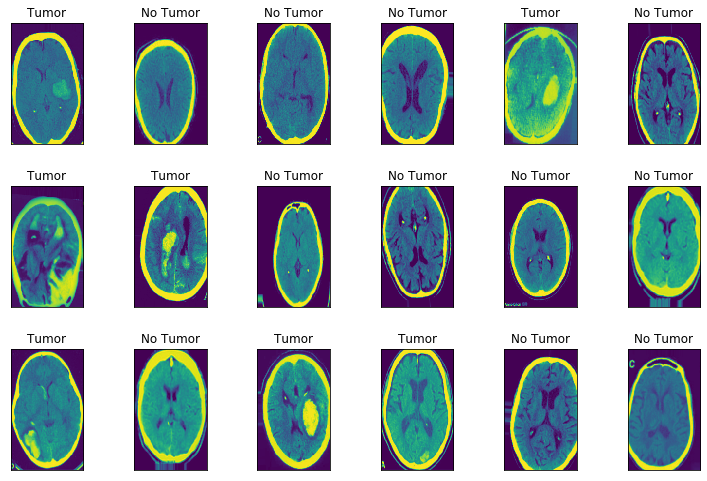

In [8]:
# plot random images
plot_gallery(data, labels, h,w)

In [9]:
print("Image Count {}".format(data.shape[0]))
print("Label Count {}".format(labels.shape[0]))

Image Count 1200
Label Count 1200


Text(0.5, 1.0, 'Class Distribution')

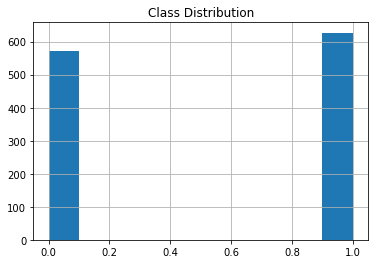

In [10]:
# Class distributions
labels_df = pd.DataFrame(data=labels)
labels_df.hist()
plt.title("Class Distribution")

### Dividing Data using 5-Fold Cross Validation

For this classificatin task I chose to use 5-fold Cross Validation in order to split up my data into training and test sets. From the start, we started out with only 200 instances in the dataset. We used image transformations to expand our data to 1200 instances. This data expansion was not only relevant because of the small size of our data, but data expansion offers the ability for the model to become averse to small variations in the orientation of an image. This versatility will result in a more effective model and will help with generalizing. Because of the small size of the dataset, there is a large amount of variance in the predictions. Cross Validation allows us to select training and testing sets while decreasing the variance overall with the 5-folds. Here we will split the data into 5 folds and will fit each Convolutional Neural Network on each of the folds. Each iteration, the CNN model builds off of the progress of the previous iteration. After fitting each CNN model on the 5 folds, we will evaluate our model on a test set created using an 80-20 split.

In [11]:
import sklearn
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True).split(data, labels)



In [12]:
#used to compare cnn models
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size= 0.20, random_state=42)

## Convolutional Neural Networks

In [13]:
import keras
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping
from sklearn.metrics import recall_score

keras.__version__


'2.1.4'

In [14]:
from keras import backend as K

#because recall metric was removed with latest version of Tf and keras, must implement ourselves using stack overflow
#https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

In [15]:
#convert labels to categorical encoded
from keras.utils import to_categorical

y_binary = to_categorical(labels)
y_train_binary = to_categorical(y_train)
y_test_binary = to_categorical(y_test)


### CNN 1 (AlexNet-Like Architecture)

The first CNN architecture that I will be implementing is similar to an AlexNet architecture. This CNN will include an extra convolution followed by a max pool. 

In [17]:
alexnet = Sequential()

alexnet.add(Conv2D(filters=32,
                   input_shape = (h,w,1),
                   kernel_size= (3,3),
                   padding='same',
                   activation='relu',
                   data_format='channels_last'))

alexnet.add(Conv2D(filters=64,
                    kernel_size=(3,3),
                    padding='same',
                    activation='relu'))
alexnet.add(MaxPooling2D(pool_size=(2,2), data_format='channels_last'))

alexnet.add(Conv2D(filters=128,
                    kernel_size=(5,5),
                    padding='same',
                    activation='relu'))
alexnet.add(MaxPooling2D(pool_size=(2,2), data_format='channels_last'))

alexnet.add(Dropout(0.25))
alexnet.add(Flatten())
alexnet.add(Dense(128, activation='relu'))
alexnet.add(Dropout(0.5))
alexnet.add(Dense(2, activation='softmax'))

alexnet.compile(loss='categorical_crossentropy',
                   optimizer='rmsprop',
                   metrics=[recall_m])




In [18]:
alexnet_fits = []
for k, (train, test) in enumerate(kfold):
    history = alexnet.fit(data[train], y_binary[train], \
                batch_size=32, \
                epochs=50, shuffle=True, verbose=1, \
                validation_data=(data[test],y_binary[test]), \
                callbacks=[EarlyStopping(monitor='val_loss', patience=2)])
    alexnet_fits.append(history)
    

Instructions for updating:
Use tf.cast instead.
Train on 960 samples, validate on 240 samples
Epoch 1/50
960/960 [==============================] - 65s 68ms/step - loss: 8.1741 - recall_m: 0.4896 - val_loss: 7.6561 - val_recall_m: 0.5250
Epoch 2/50
960/960 [==============================] - 64s 67ms/step - loss: 7.8408 - recall_m: 0.5135 - val_loss: 7.6561 - val_recall_m: 0.5250
Epoch 3/50
960/960 [==============================] - 64s 67ms/step - loss: 7.8283 - recall_m: 0.5135 - val_loss: 7.6561 - val_recall_m: 0.5250
Train on 960 samples, validate on 240 samples
Epoch 1/50
960/960 [==============================] - 65s 67ms/step - loss: 7.7065 - recall_m: 0.5219 - val_loss: 7.6561 - val_recall_m: 0.5250
Epoch 2/50
960/960 [==============================] - 64s 67ms/step - loss: 7.7233 - recall_m: 0.5208 - val_loss: 7.6561 - val_recall_m: 0.5250
Epoch 3/50
960/960 [==============================] - 64s 67ms/step - loss: 7.7233 - recall_m: 0.5208 - val_loss: 7.6561 - val_recall_m: 0.5

##### Optional Save to Disk

In [20]:
from keras.models import model_from_json

alexnet_json = alexnet.to_json()
with open("alexnet.json", "w") as json_file:
    json_file.write(alexnet_json)
# serialize weights to HDF5
alexnet.save_weights("alexnet.h5")

print("Saved model to disk")

Saved model to disk


In [16]:
from keras.models import model_from_json
# load json and create model
json_file = open('alexnet.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
alexnet = model_from_json(loaded_model_json)
# load weights into new model
alexnet.load_weights("alexnet.h5")

print("Loaded model from disk")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Loaded model from disk


#### Visualize performance over iterations

Text(0.5, 0, 'epochs')

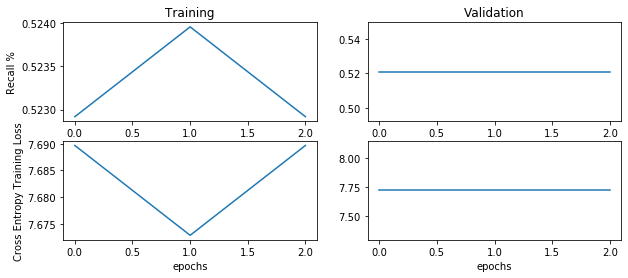

In [21]:
from matplotlib import pyplot as plt

%matplotlib inline

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(alexnet_fits[-1].history['recall_m'])

plt.ylabel('Recall %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(alexnet_fits[-1].history['val_recall_m'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(alexnet_fits[-1].history['loss'])
plt.ylabel('Cross Entropy Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(alexnet_fits[-1].history['val_loss'])
plt.xlabel('epochs')

#### Alexnet-Like with different params 

This architecture is the same as before, however now we will be using all 5 x 5 kernels as well as only 4 x 4 max pools instead of the original 2 x 2.

In [22]:
alexnet2 = Sequential()

alexnet2.add(Conv2D(filters=32,
                   input_shape = (h,w,1),
                   kernel_size= (5,5),
                   padding='same',
                   activation='relu',
                   data_format='channels_last'))

alexnet2.add(Conv2D(filters=64,
                    kernel_size=(5,5),
                    padding='same',
                    activation='relu'))
alexnet2.add(MaxPooling2D(pool_size=(4,4), data_format='channels_last'))

alexnet2.add(Conv2D(filters=128,
                    kernel_size=(5,5),
                    padding='same',
                    activation='relu'))
alexnet2.add(MaxPooling2D(pool_size=(4,4), data_format='channels_last'))

alexnet2.add(Dropout(0.25))
alexnet2.add(Flatten())
alexnet2.add(Dense(128, activation='relu'))
alexnet2.add(Dropout(0.5))
alexnet2.add(Dense(2, activation='softmax'))

alexnet2.compile(loss='categorical_crossentropy',
                   optimizer='rmsprop',
                   metrics=[recall_m])


In [23]:
kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True).split(data, labels)


alexnet2_fits = []
for k, (train, test) in enumerate(kfold):
    history = alexnet2.fit(data[train], y_binary[train], \
                batch_size=32, \
                epochs=50, shuffle=True, verbose=1, \
                validation_data=(data[test],y_binary[test]), \
                callbacks=[EarlyStopping(monitor='val_loss', patience=2)])
    alexnet2_fits.append(history)

Train on 960 samples, validate on 240 samples
Epoch 1/50
960/960 [==============================] - 70s 73ms/step - loss: 7.7065 - recall_m: 0.5219 - val_loss: 7.6561 - val_recall_m: 0.5250
Epoch 2/50
960/960 [==============================] - 69s 72ms/step - loss: 7.7065 - recall_m: 0.5219 - val_loss: 7.6561 - val_recall_m: 0.5250
Epoch 3/50
960/960 [==============================] - 69s 72ms/step - loss: 7.7065 - recall_m: 0.5219 - val_loss: 7.6561 - val_recall_m: 0.5250
Train on 960 samples, validate on 240 samples
Epoch 1/50
960/960 [==============================] - 69s 72ms/step - loss: 7.7065 - recall_m: 0.5219 - val_loss: 7.6561 - val_recall_m: 0.5250
Epoch 2/50
960/960 [==============================] - 69s 72ms/step - loss: 7.7065 - recall_m: 0.5219 - val_loss: 7.6561 - val_recall_m: 0.5250
Epoch 3/50
960/960 [==============================] - 69s 72ms/step - loss: 7.7065 - recall_m: 0.5219 - val_loss: 7.6561 - val_recall_m: 0.5250
Train on 960 samples, validate on 240 sample

Text(0.5, 0, 'epochs')

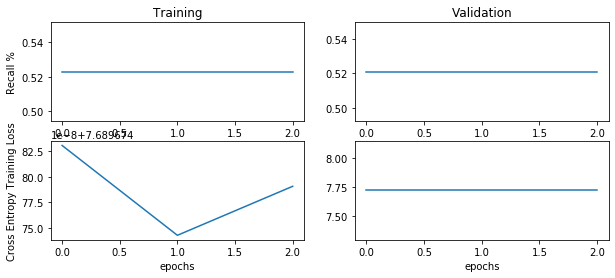

In [24]:

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(alexnet2_fits[-1].history['recall_m'])

plt.ylabel('Recall %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(alexnet2_fits[-1].history['val_recall_m'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(alexnet2_fits[-1].history['loss'])
plt.ylabel('Cross Entropy Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(alexnet2_fits[-1].history['val_loss'])
plt.xlabel('epochs')

In [25]:
alexnet2_json = alexnet2.to_json()
with open("alexnet2.json", "w") as json_file:
    json_file.write(alexnet2_json)
# serialize weights to HDF5
alexnet2.save_weights("alexnet2.h5")

print("Saved model to disk")

Saved model to disk


In [16]:
from keras.models import model_from_json
# load json and create model
json_file = open('alexnet.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
alexnet = model_from_json(loaded_model_json)
# load weights into new model
alexnet.load_weights("alexnet.h5")

print("Loaded model from disk")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Loaded model from disk


### Comparison Between Alexnet Architectures

In [72]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

'''ROC and AUC for AlexNet'''
y_pred_alex1 = np.argmax(alexnet.predict(X_test), axis=1)

#false positve and true postive rates using roc
fpr_alex1, tpr_alex1, thresholds_alex1 = roc_curve(np.argmax(y_test_binary,axis=1), y_pred_alex1)

#area under the curve
auc_alex1 = auc(fpr_alex1, tpr_alex1)

'''ROC and AUC for AlexNet2'''
y_pred_alex2 = np.argmax(alexnet2.predict(X_test), axis=1)

#false positve and true postive rates using roc
fpr_alex2, tpr_alex2, thresholds_alex2 = roc_curve(np.argmax(y_test_binary, axis=1), y_pred_alex2)

#area under the curve
auc_alex2 = auc(fpr_alex2, tpr_alex2)


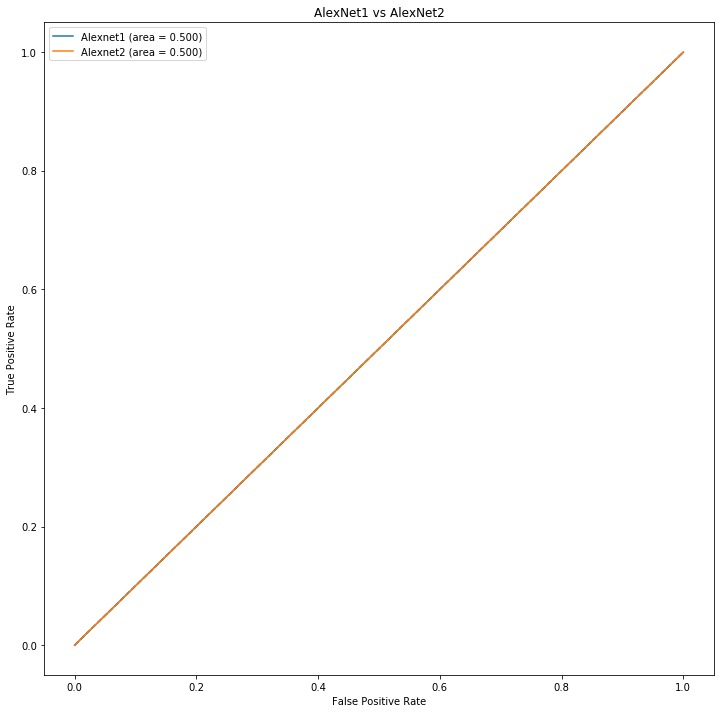

In [78]:
plt.figure(figsize=(12,12))

#plot halfway line
plt.plot([0,1], [0,1], 'k--')

#plot alexnet ROC
plt.plot(fpr_alex1, tpr_alex1, label='Alexnet1 (area = {:.3f})'.format(auc_alex1))

#plot alexnet2 ROC
plt.plot(fpr_alex2, tpr_alex2, label='Alexnet2 (area = {:.3f})'.format(auc_alex2))


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AlexNet1 vs AlexNet2')
plt.legend(loc='best')
plt.show()


As shown above in the ROC curve, both AlexNet implementations performed at chance, hinting that this architecture does a poor job in identifying brain tumors. The implementations are similar to one another because the only difference between the two is the filter shapes and pooling sizes.

### CNN 2

In [32]:
eliNet = Sequential()

eliNet.add(Conv2D(filters=16,
                    input_shape = (h,w,1),
                    kernel_size=(3,3),
                    padding='same',
                    activation='relu',))

eliNet.add(Conv2D(filters=32,
                    kernel_size=(3,3),
                    padding='same',
                    activation='relu'))

eliNet.add(MaxPooling2D(pool_size=(2,2), data_format='channels_last'))

eliNet.add(Conv2D(filters=64,
                    kernel_size=(3,3),
                    padding='same',
                    activation='relu'))

eliNet.add(MaxPooling2D(pool_size=(4,4), data_format='channels_last'))

eliNet.add(Conv2D(filters=128,
                    kernel_size=(3,3),
                    padding='same',
                    activation='relu'))

eliNet.add(MaxPooling2D(pool_size=(8,8), data_format='channels_last'))

eliNet.add(Dropout(0.25))
eliNet.add(Flatten())
eliNet.add(Dense(128, activation='relu'))
eliNet.add(Dropout(0.25))
eliNet.add(Dense(64, activation='relu'))
eliNet.add(Dropout(0.5))
eliNet.add(Dense(2, activation='softmax'))

eliNet.compile(loss='categorical_crossentropy',
                   optimizer='rmsprop',
                   metrics=[recall_m])



In [33]:
kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True).split(data, labels)

eliNet_fits = []
for k, (train, test) in enumerate(kfold):
    history = eliNet.fit(data[train], y_binary[train], \
                batch_size=32, \
                epochs=50, shuffle=True, verbose=1, \
                validation_data=(data[test],y_binary[test]), \
                callbacks=[EarlyStopping(monitor='val_loss', patience=2)])
    eliNet_fits.append(history)

Train on 960 samples, validate on 240 samples
Epoch 1/50
960/960 [==============================] - 18s 19ms/step - loss: 3.5857 - recall_m: 0.5323 - val_loss: 0.7571 - val_recall_m: 0.4667
Epoch 2/50
960/960 [==============================] - 18s 18ms/step - loss: 0.7277 - recall_m: 0.5469 - val_loss: 0.6815 - val_recall_m: 0.6167
Epoch 3/50
960/960 [==============================] - 18s 18ms/step - loss: 0.6945 - recall_m: 0.5531 - val_loss: 0.6625 - val_recall_m: 0.6375
Epoch 4/50
960/960 [==============================] - 18s 18ms/step - loss: 0.6942 - recall_m: 0.5854 - val_loss: 0.6428 - val_recall_m: 0.6792
Epoch 5/50
960/960 [==============================] - 18s 19ms/step - loss: 0.6698 - recall_m: 0.6260 - val_loss: 0.5891 - val_recall_m: 0.7125
Epoch 6/50
960/960 [==============================] - 18s 18ms/step - loss: 0.6096 - recall_m: 0.7104 - val_loss: 0.6404 - val_recall_m: 0.6458
Epoch 7/50
960/960 [==============================] - 18s 18ms/step - loss: 0.5230 - recal

In [34]:
eliNet_json = eliNet.to_json()
with open("eliNet.json", "w") as json_file:
    json_file.write(eliNet_json)
# serialize weights to HDF5
eliNet.save_weights("eliNet.h5")

print("Saved model to disk")

Saved model to disk


In [16]:
from keras.models import model_from_json
# load json and create model
json_file = open('eliNet.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
eliNet = model_from_json(loaded_model_json)
# load weights into new model
eliNet.load_weights("eliNet.h5")

print("Loaded model from disk")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Loaded model from disk


Text(0.5, 0, 'epochs')

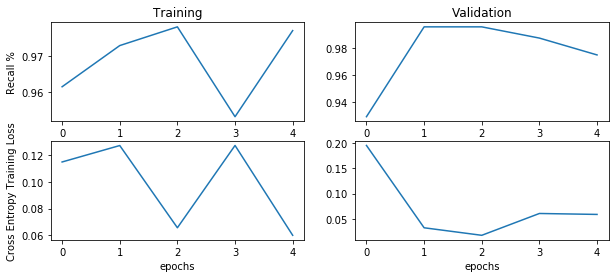

In [35]:
from matplotlib import pyplot as plt

%matplotlib inline

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(eliNet_fits[-1].history['recall_m'])

plt.ylabel('Recall %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(eliNet_fits[-1].history['val_recall_m'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(eliNet_fits[-1].history['loss'])
plt.ylabel('Cross Entropy Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(eliNet_fits[-1].history['val_loss'])
plt.xlabel('epochs')

#### CNN 2 with param changes

This architecture is a modified eliNet CNN where instead of increasing the filter count from 16 -> 32 -> 64 -> 128, the filters increase from 32 -> 64 -> 64 -> 128. Other changes include larger 5 x 5 kernels for the first two convolutions followed by 3 x 3 kernel sizes in the last convolutions. The final parameter changes to the eliNet architecture are the decreasing max pool sizes. The first max pool was changed to a 4 x 4 max pool and the last two were changed to a 2 x 2 max pool.

In [36]:
eliNet2 = Sequential()

eliNet2.add(Conv2D(filters=32,
                    input_shape = (h,w,1),
                    kernel_size=(5,5),
                    padding='same',
                    activation='relu',
                    ))

eliNet2.add(Conv2D(filters=64,
                    kernel_size=(5,5),
                    padding='same',
                    activation='relu'))

eliNet2.add(MaxPooling2D(pool_size=(4,4), data_format='channels_last'))

eliNet2.add(Conv2D(filters=64,
                    kernel_size=(3,3),
                    padding='same',
                    activation='relu'))

eliNet2.add(MaxPooling2D(pool_size=(2,2), data_format='channels_last'))

eliNet2.add(Conv2D(filters=128,
                    kernel_size=(3,3),
                    padding='same',
                    activation='relu'))

eliNet2.add(MaxPooling2D(pool_size=(2,2), data_format='channels_last'))

eliNet2.add(Dropout(0.25))
eliNet2.add(Flatten())
eliNet2.add(Dense(128, activation='relu'))
eliNet2.add(Dropout(0.25))
eliNet2.add(Dense(64, activation='relu'))
eliNet2.add(Dropout(0.5))
eliNet2.add(Dense(2, activation='softmax'))

eliNet2.compile(loss='categorical_crossentropy',
                   optimizer='rmsprop',
                   metrics=[recall_m])




In [115]:
eliNet2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 250, 150, 32)      832       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 250, 150, 64)      51264     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 62, 37, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 62, 37, 64)        36928     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 31, 18, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 31, 18, 128)       73856     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 15, 9, 128)        0         
__________

In [38]:
kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True).split(data, labels)

eliNet2_fits = []
for k, (train, test) in enumerate(kfold):
    history = eliNet2.fit(data[train], y_binary[train], \
                batch_size=32, \
                epochs=50, shuffle=True, verbose=1, \
                validation_data=(data[test],y_binary[test]), \
                callbacks=[EarlyStopping(monitor='val_loss', patience=2)])
    eliNet2_fits.append(history)

Train on 960 samples, validate on 240 samples
Epoch 1/50
960/960 [==============================] - 66s 69ms/step - loss: 8.5051 - recall_m: 0.4677 - val_loss: 8.4620 - val_recall_m: 0.4750
Epoch 2/50
960/960 [==============================] - 65s 68ms/step - loss: 8.5424 - recall_m: 0.4698 - val_loss: 8.4620 - val_recall_m: 0.4750
Epoch 3/50
960/960 [==============================] - 65s 68ms/step - loss: 8.3691 - recall_m: 0.4802 - val_loss: 8.4620 - val_recall_m: 0.4750
Train on 960 samples, validate on 240 samples
Epoch 1/50
960/960 [==============================] - 65s 68ms/step - loss: 8.5627 - recall_m: 0.4688 - val_loss: 8.4620 - val_recall_m: 0.4750
Epoch 2/50
960/960 [==============================] - 65s 68ms/step - loss: 8.6415 - recall_m: 0.4635 - val_loss: 7.6561 - val_recall_m: 0.5250
Epoch 3/50
960/960 [==============================] - 65s 68ms/step - loss: 7.7690 - recall_m: 0.5177 - val_loss: 7.6561 - val_recall_m: 0.5250
Epoch 4/50
960/960 [========================

In [39]:
eliNet2_json = eliNet2.to_json()
with open("eliNet2.json", "w") as json_file:
    json_file.write(eliNet2_json)
# serialize weights to HDF5
eliNet2.save_weights("eliNet2.h5")

print("Saved model to disk")

Saved model to disk


In [16]:
from keras.models import model_from_json
# load json and create model
json_file = open('eliNet2.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
eliNet2 = model_from_json(loaded_model_json)
# load weights into new model
eliNet2.load_weights("eliNet2.h5")

print("Loaded model from disk")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Loaded model from disk


Text(0.5, 0, 'epochs')

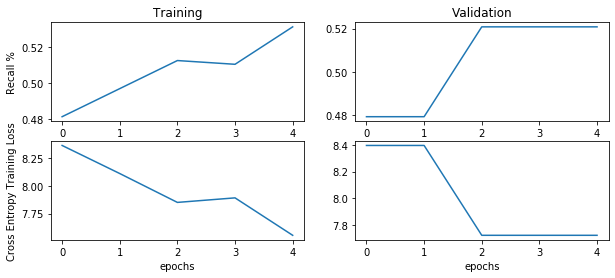

In [40]:
from matplotlib import pyplot as plt

%matplotlib inline

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(eliNet2_fits[-1].history['recall_m'])

plt.ylabel('Recall %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(eliNet2_fits[-1].history['val_recall_m'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(eliNet2_fits[-1].history['loss'])
plt.ylabel('Cross Entropy Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(eliNet2_fits[-1].history['val_loss'])
plt.xlabel('epochs')

### Comparison Between eliNet Architectures

In [75]:

'''ROC and AUC for eliNet'''
y_pred_eli1 = np.argmax(eliNet.predict(X_test), axis=1)

#false positve and true postive rates using roc
fpr_eli1, tpr_eli1, thresholds_eli1 = roc_curve(np.argmax(y_test_binary,axis=1), y_pred_eli1)

#area under the curve
auc_eli1 = auc(fpr_eli1, tpr_eli1)

'''ROC and AUC for eliNet2'''
y_pred_eli2 = np.argmax(eliNet2.predict(X_test), axis=1)

#false positve and true postive rates using roc
fpr_eli2, tpr_eli2, thresholds_eli2 = roc_curve(np.argmax(y_test_binary, axis=1), y_pred_eli2)

#area under the curve
auc_eli2 = auc(fpr_eli2, tpr_eli2)


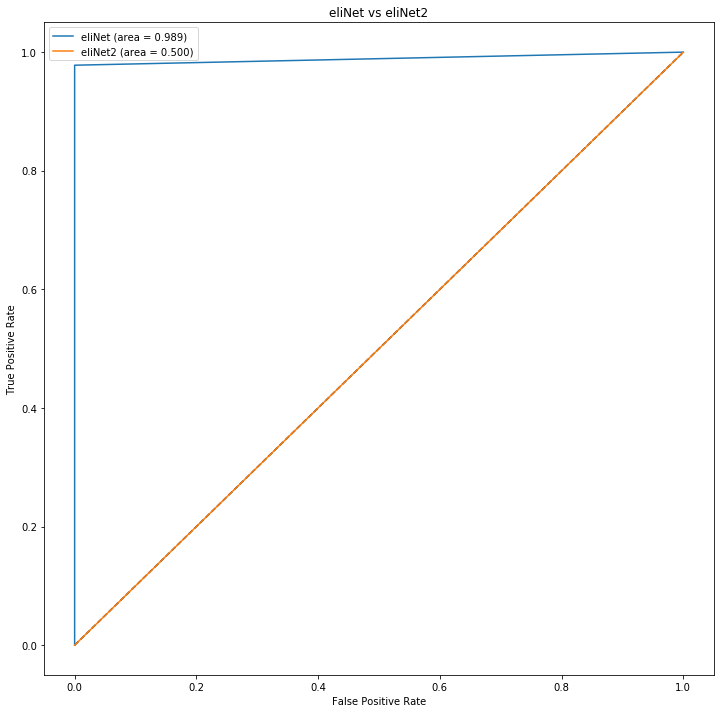

In [77]:
plt.figure(figsize=(12,12))

#plot halfway line
plt.plot([0,1], [0,1], 'k--')

#plot eliNet ROC
plt.plot(fpr_eli1, tpr_eli1, label='eliNet (area = {:.3f})'.format(auc_eli1))

#plot eliNet2 ROC
plt.plot(fpr_eli2, tpr_eli2, label='eliNet2 (area = {:.3f})'.format(auc_eli2))


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('eliNet vs eliNet2')
plt.legend(loc='best')
plt.show()


From the ROC curve above we see that the eliNet implementation outperformed the eliNet2 implementation significantly. The second implementation performed at chance which is interesting considering both follow the same architecture, but have different parameter values. These results suggest that increasing the filter sizes or having large max pools followed by smaller max pools deteriorates the effectiveness of the model.

### Comparison Between AlexNet and eliNet

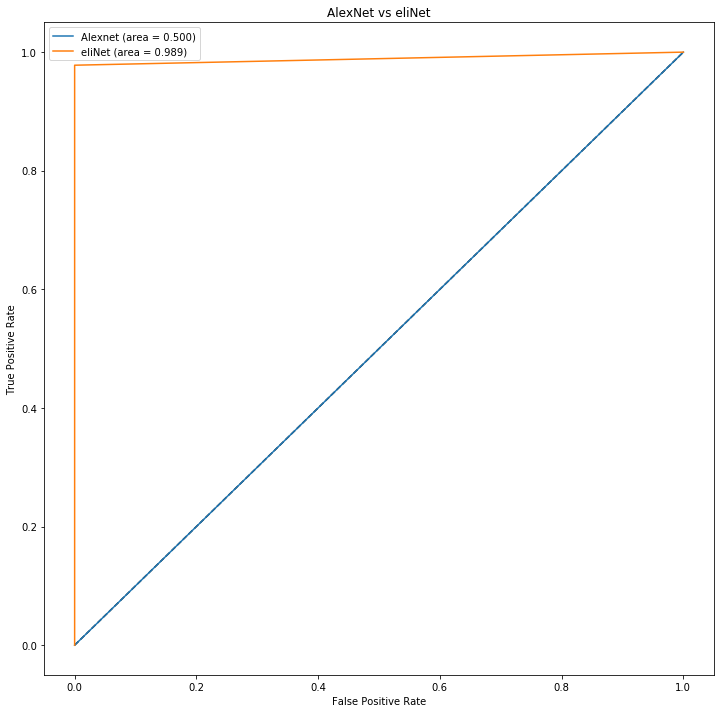

In [79]:
plt.figure(figsize=(12,12))

#plot halfway line
plt.plot([0,1], [0,1], 'k--')

#plot alexnet ROC
plt.plot(fpr_alex1, tpr_alex1, label='Alexnet (area = {:.3f})'.format(auc_alex1))

#plot eliNet ROC
plt.plot(fpr_eli1, tpr_eli1, label='eliNet (area = {:.3f})'.format(auc_eli1))


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AlexNet vs eliNet')
plt.legend(loc='best')
plt.show()

From the ROC curve above, we clearly see that eliNet outperformed AlexNet for predicting brain tumors, with an AUC of 0.989. This demonstrates the art of deep learning, meaning that a lot of the times effective architectures are created by simply trying things out and testing different combinations of filters empirically. Here eliNet outperformed AlexNet which could likely be because of the extra dense layer added to eliNet. But the results could also be because of other factors like the filter sizes, dropout, and pooling techniques.

### Compare CNN with Multilayer Perceptron 

In [69]:
flat_train = np.asarray([x.flatten() for x in X_train ])
flat_test = np.asarray([x.flatten() for x in X_test])
flat_train.shape

(960, 37500)

In [61]:
mlp = Sequential()
mlp.add( Dense(input_dim=flat_train.shape[1], units=30, activation='relu') )
mlp.add( Dense(units=15, activation='relu') )
mlp.add( Dense(2) )
mlp.add( Activation('softmax') )

mlp.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=[recall_m])

mlp.fit(flat_train, y_train_binary, 
        batch_size=32, epochs=150, 
        shuffle=True, verbose=0)

In [70]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

'''ROC and AUC for CNN'''
y_pred_cnn = np.argmax(eliNet.predict(X_test), axis=1)

#false positve and true postive rates using roc
fpr_cnn, tpr_cnn, thresholds_cnn = roc_curve(np.argmax(y_test_binary,axis=1), y_pred_cnn)

#area under the curve
auc_cnn = auc(fpr_cnn, tpr_cnn)

'''ROC and AUC for MLP'''
y_pred_mlp = np.argmax(mlp.predict(flat_test), axis=1)

#false positve and true postive rates using roc
fpr_mlp, tpr_mlp, thresholds_mlp = roc_curve(np.argmax(y_test_binary, axis=1), y_pred_mlp)

#area under the curve
auc_mlp = auc(fpr_mlp, tpr_mlp)


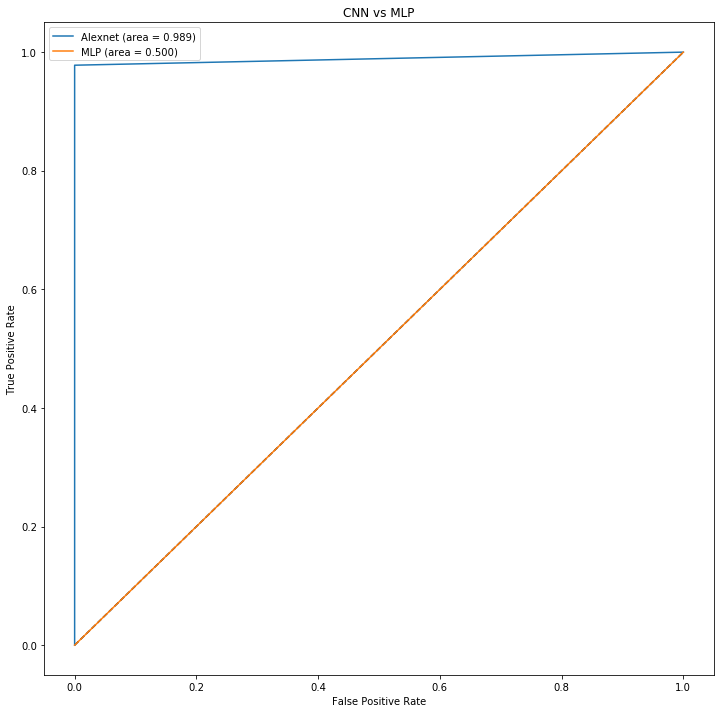

In [71]:
plt.figure(figsize=(12,12))

#plot halfway line
plt.plot([0,1], [0,1], 'k--')

#plot model 1 ROC
plt.plot(fpr_cnn, tpr_cnn, label='Alexnet (area = {:.3f})'.format(auc_cnn))

#plot model 2 ROC
plt.plot(fpr_mlp, tpr_mlp, label='MLP (area = {:.3f})'.format(auc_mlp))


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CNN vs MLP')
plt.legend(loc='best')
plt.show()


From the ROC curve above, we can clearly see that the eliNet architecture outperformed the standard multilayer perceptron. The MLP performed at roughly 50 percent or chance, while the eliNet CNN performed with 98 percent recall. This clear performance difference is likely due to the CNN's ability to learn features of images with filters. The ROC curve supports the practice of using CNNs to perform image classification tasks instead of MLPs due to their advanced feature learning techniques.

### Comparing Pre-trained Models to our Architectures

In [96]:
#convert to three channels
x_train = [img.reshape((250,150)) for img in X_train]
x_train = np.stack(x_train, axis=0)
x_train = np.stack((x_train,)*3, axis=-1)

x_test = [img.reshape((250,150)) for img in X_test]
x_test = np.stack(x_test, axis=0)
x_test = np.stack((x_test,)*3, axis=-1)

print("x_train shape: ", x_train.shape)
print("x_test shape: ", x_test.shape)

x_train shape:  (960, 250, 150, 3)
x_test shape:  (240, 250, 150, 3)


In [129]:
# manipulated from Keras Documentation
#  https://keras.io/applications/
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

# load only convolutional layers of resnet:
if 'res_no_top' not in locals():
    resnet = ResNet50(weights='imagenet', include_top=False)
    
x = x_train[0]
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

%time preds = resnet.predict(x)


X_resnet_train = resnet.predict(x_train)
X_resnet_test = resnet.predict(x_test)



CPU times: user 5.57 s, sys: 84 ms, total: 5.65 s
Wall time: 4.62 s


In [130]:
X_resnet_train.shape

(960, 1, 0, 2048)

In [122]:
x = np.expand_dims(flat_train, axis=2)

In [131]:
from keras.layers import SeparableConv2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Add, Flatten, Dense
from keras.layers import average, concatenate
from keras.models import Input, Model

input_x = Input(shape= X_resnet_train[0].shape)
x = Flatten()(input_x)
x = Dense(200, activation='relu',kernel_initializer='he_uniform')(input_x)
# and a fully connected layer 
predictions = Dense(2, activation='softmax', kernel_initializer='glorot_uniform')(x)

model = Model(inputs=input_x, outputs=predictions)

model.summary()

ValueError: The shape of the input to "Flatten" is not fully defined (got (1, 0, 2048). Make sure to pass a complete "input_shape" or "batch_input_shape" argument to the first layer in your model.

In [124]:
y_resnet_train = y_train[:X_resnet_train.shape[0]]

model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=[recall_m])

model.fit(x,y_resnet_train,epochs=5,
          batch_size=64,verbose=1)

AttributeError: 'Tensor' object has no attribute 'ndim'

The ResNet50 predict returned a shape that would not flatten, which prevented the use of transfer learning.

## References


* [1] https://www.cancer.net/cancer-types/brain-tumor/statistics
* [2] https://weillcornellbrainandspine.org/early-detection-can-be-key-surviving-brain-tumor
* [3] https://jnnp.bmj.com/content/75/suppl_2/ii18